In [2]:
# ! pip install seaborn numpy scikit-learn

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()  # looks for a .env file in the current working directory

# Now you can access them

True

In [2]:
import os
from mistralai import Mistral


api_key = os.getenv("MISTRAL_API_KEY")
model = "mistral-embed"

client = Mistral(api_key=api_key)

embeddings_batch_response = client.embeddings.create(
    model=model,
    inputs=["Embed this sentence.", "As well as this one."],
)

In [3]:
len(embeddings_batch_response.data[0].embedding)

1024

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

def get_text_embedding(inputs):
    embeddings_batch_response = client.embeddings.create(
        model=model,
        inputs=inputs
    )
    return embeddings_batch_response.data[0].embedding

In [5]:
sentences = [
    "A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title?",
    "I think books are like people, in the sense that they’ll turn up in your life when you most need them"
]
embeddings = [get_text_embedding([t]) for t in sentences]

In [6]:
reference_sentence = "Books are mirrors: You only see in them what you already have inside you"
reference_embedding = get_text_embedding([reference_sentence])

In [7]:
for t, e in zip(sentences, embeddings):
    distance = euclidean_distances([e], [reference_embedding])
    print(t, distance)

A home without a cat — and a well-fed, well-petted and properly revered cat — may be a perfect home, perhaps, but how can it prove title? [[0.80115313]]
I think books are like people, in the sense that they’ll turn up in your life when you most need them [[0.58192809]]


In [8]:
sentences = [
    'Have a safe happy Memorial Day weekend everyone',
    'To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend',
    'Where can I find the best cheese?'
]

In [9]:
sentence_embeddings = [get_text_embedding([t]) for t in sentences]

In [10]:
import itertools

sentence_embeddings_pairs = list(itertools.combinations(sentence_embeddings, 2))
sentence_pairs = list(itertools.combinations(sentences, 2))

In [11]:
for s, e in zip(sentence_pairs, sentence_embeddings_pairs):
    print(s, euclidean_distances([e[0]], [e[1]]))

('Have a safe happy Memorial Day weekend everyone', 'To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend') [[0.54402904]]
('Have a safe happy Memorial Day weekend everyone', 'Where can I find the best cheese?') [[0.92663136]]
('To all our friends at Whatsit Productions Films enjoy a safe happy Memorial Day weekend', 'Where can I find the best cheese?') [[0.91251491]]


In [12]:
import pandas as pd
df = pd.read_csv('sample_data/Symptom2Disease.csv')

In [13]:
df.shape

(1200, 2)

In [14]:
def get_embeddings_by_chunks(data, chunk_size):
    chunks = [data[x : x + chunk_size] for x in range(0, len(data), chunk_size)]
    embeddings_response = [
        client.embeddings.create(model=model, inputs=c) for c in chunks
    ]
    return [d.embedding for e in embeddings_response for d in e.data]

In [15]:
df['embeddings'] = get_embeddings_by_chunks(df['text'].tolist(), 50)

In [16]:
df.head()

label                                               text  \
0  Psoriasis  I have been experiencing a skin rash on my arm...   
1  Psoriasis  My skin has been peeling, especially on my kne...   
2  Psoriasis  I have been experiencing joint pain in my fing...   
3  Psoriasis  There is a silver like dusting on my skin, esp...   
4  Psoriasis  My nails have small dents or pits in them, and...   

                                          embeddings  
0  [-0.036376953125, 0.041046142578125, 0.0733032...  
1  [-0.053741455078125, 0.05218505859375, 0.07421...  
2  [-0.035064697265625, 0.0262908935546875, 0.036...  
3  [-0.0361328125, 0.056976318359375, 0.053009033...  
4  [-0.0251617431640625, 0.039703369140625, 0.047...

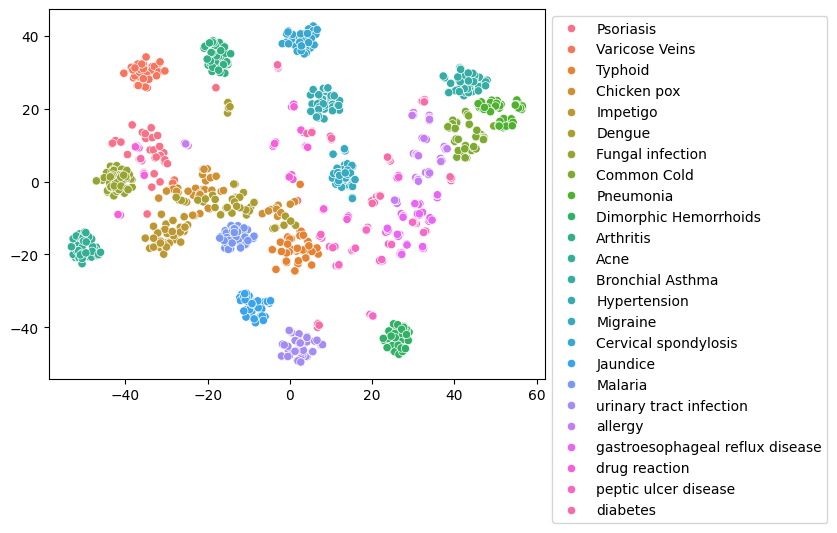

In [17]:
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np


tsne = TSNE(n_components=2, random_state=0).fit_transform(np.array(df['embeddings'].to_list()))
ax = sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=np.array(df['label'].to_list()))
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [21]:
# Create a train / test split

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df['embeddings'], df["label"],test_size=0.2)

In [22]:
# Normalize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x.to_list())
test_x = scaler.transform(test_x.to_list())

In [23]:
# Train a classifier and compute the test accuracy

from sklearn.linear_model import LogisticRegression

# For a real problem, C should be properly cross validated and the confusion matrix analyzed
clf = LogisticRegression(random_state=0, C=1.0, max_iter=500).fit(train_x, train_y.to_list()) 

# you can also try the sag algorithm:
# clf = LogisticRegression(random_state=0, C=1.0, max_iter=1000, solver='sag').fit(train_x, train_y)

print(f"Precision: {100*np.mean(clf.predict(test_x) == test_y.to_list()):.2f}%")

Precision: 99.17%


In [24]:
# Classify a single example
text = "I've been experiencing frequent headaches and vision problems."
clf.predict([get_text_embedding([text])])

array(['Migraine'], dtype='<U31')